In [1]:
from typing import Optional

import numpy as np
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import seaborn as sns
import pandas as pd


from pathlib import Path
from data_generation.spectral_density import arma_spectral_density
import pandas as pd

from lrv_test import LRV
from lrv_test.types import real_function

from data_generation.arma import generate_arma_sample

import seaborn as sns

sns.set_style("whitegrid")

# Limit distribution check

In [2]:
def run(
    f: real_function,
    N: int,
    M: int,
    B: int,
    ar: float,
    ma: float,
    freqs: np.ndarray,
    is_complex_gaussian: bool,
    oracle_sd: Optional[real_function] = None,
    L: Optional[int] = None,
) -> dict:
    y = generate_arma_sample(N, M, ar, ma, is_complex_gaussian)
    lrv = LRV(y, B, f, freqs=freqs, L=L, sd=oracle_sd)
    return {
        "lrv": lrv,
        "freqs": freqs,
        "ar": ar,
        "ma": ma,
        "N": N,
        "M": M,
        "B": B,
        "is_complex_gaussian": is_complex_gaussian,
        # "oracle_sd": oracle_sd,
        "L": L,
    }

In [3]:
N_range = np.arange(1_000, 8_000, 2_000)
N_range = np.arange(20_000, 21_000, 2_000)
alpha_range = np.arange(0.5, 1.0, 0.05)
c = 1 / 2

# Define the function / frequencies to test
f = lambda x: (x - 1) ** 2


def freqs(B, N):
    return np.arange(-0.4, 0.6, B / N)


# Define once properties of the arma process to generate
ar, ma = 0.1, 0.5

# Define the number of repetitions
n_repeat = 10**1

# storage path
storage_path = Path("./plots/clt_arma_large_alpha")
storage_path.mkdir(parents=True, exist_ok=True)

In [4]:
tasks = []

for is_oracle in [True]:  # [True, False]:
    if is_oracle:
        oracle_sd = arma_spectral_density(ar, ma)
        L = None
    else:
        oracle_sd = None
        L = int(N**0.15)

    for is_complex_gaussian in [True]:  # [True, False]:
        for N in N_range:
            for alpha in alpha_range:
                M = int(N**alpha)
                B = int(M / c)
                if B % 2 == 0:
                    B += 1

                if B > N:
                    continue

                freqs_values = freqs(B, N)

                task = {
                    "f": f,
                    "freqs": freqs_values,
                    "N": N,
                    "M": M,
                    "B": B,
                    "ar": ar,
                    "ma": ma,
                    "is_complex_gaussian": is_complex_gaussian,
                    "oracle_sd": oracle_sd,
                    "L": L,
                }
                tasks += [task.copy() for _ in range(n_repeat)]

# shuffle the tasks to make sure to distribute the load through time
np.random.shuffle(tasks)

len(tasks)

90

In [5]:
results = Parallel(n_jobs=1)(delayed(run)(**task) for task in tqdm(tasks))

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [1:10:00<00:00, 46.67s/it] 


In [8]:
# save results as pickle

import pickle

with open(storage_path / "results.pkl", "wb") as f:
    pickle.dump(results, f)

In [16]:
expanded_results = []

for result in results:
    lrv = result["lrv"]
    freqs = result["freqs"]
    ar = result["ar"]
    ma = result["ma"]
    N = result["N"]
    M = result["M"]
    B = result["B"]
    is_complex_gaussian = result["is_complex_gaussian"]
    # oracle_sd = result["oracle_sd"]
    L = result["L"]

    is_oracle = oracle_sd is not None

    alpha = np.log(M) / np.log(N)
    # round alpha to the closest in the alpha_range
    min_idx = np.argmin(np.abs(alpha_range - alpha))
    alpha = alpha_range[min_idx]

    for t_stat in ["t_stat_1", "t_stat_2", "t_stat_3", "t_stat_4"]:
        expanded_result = {
            "lrv": getattr(lrv, t_stat),
            "lrv_stat": t_stat,
            "ar": ar,
            "ma": ma,
            "N": N,
            "M": M,
            "B": B,
            "is_complex_gaussian": is_complex_gaussian,
            "is_oracle": is_oracle,
            "alpha": alpha,
        }
        expanded_results.append(expanded_result)

df = pd.DataFrame(expanded_results)

In [17]:
df

,lrv,lrv_stat,ar,ma,N,M,B,is_complex_gaussian,is_oracle,alpha
0,1.826588e-01,t_stat_1,0.1,0.5,20000,624,1249,True,True,0.65
1,6.711204e-01,t_stat_2,0.1,0.5,20000,624,1249,True,True,0.65
2,2.091327e+01,t_stat_3,0.1,0.5,20000,624,1249,True,True,0.65
3,1.210233e+00,t_stat_4,0.1,0.5,20000,624,1249,True,True,0.65
4,-3.615485e+02,t_stat_1,0.1,0.5,20000,2759,5519,True,True,0.80
...,...,...,...,...,...,...,...,...,...,...
355,2.008169e+01,t_stat_4,0.1,0.5,20000,1024,2049,True,True,0.70
356,-2.269606e+04,t_stat_1,0.1,0.5,20000,7428,14857,True,True,0.90
357,2.603122e+08,t_stat_2,0.1,0.5,20000,7428,14857,True,True,0.90
358,5.206245e+08,t_stat_3,0.1,0.5,20000,7428,14857,True,True,0.90


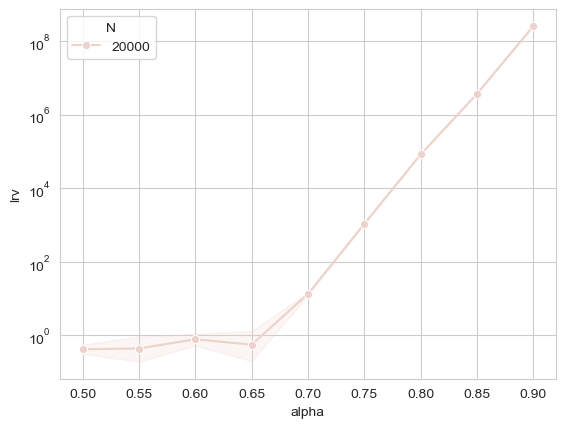

In [20]:
fig, ax = plt.subplots()

# ax.set_xscale('log')
ax.set_yscale("log")

sub_df = df[df["lrv_stat"] == "t_stat_2"]
sub_df = sub_df[sub_df["is_oracle"] == True]
sub_df = sub_df[sub_df["is_complex_gaussian"] == True]

sns.lineplot(
    sub_df[["alpha", "lrv", "is_complex_gaussian", "N"]].abs(),
    x="alpha",
    y="lrv",
    hue="N",
    errorbar=("ci", 95),
    marker="o",
    ax=ax,
)

# save fig
fig.savefig(storage_path / "clt_arma_large_alpha.png")

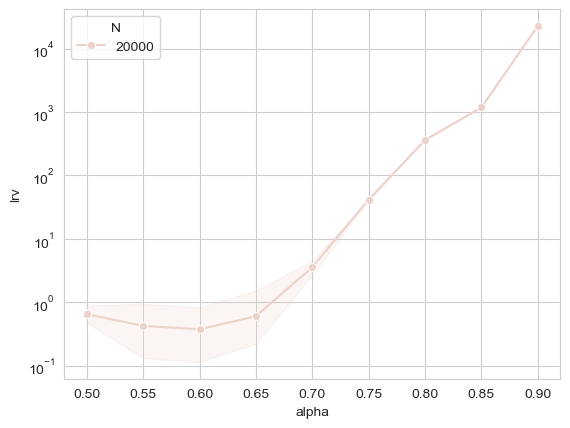

In [21]:
fig, ax = plt.subplots()

# ax.set_xscale('log')
ax.set_yscale("log")

sub_df = df[df["lrv_stat"] == "t_stat_1"]
sub_df = sub_df[sub_df["is_oracle"] == True]
sub_df = sub_df[sub_df["is_complex_gaussian"] == True]

sns.lineplot(
    sub_df[["alpha", "lrv", "is_complex_gaussian", "N"]].abs(),
    x="alpha",
    y="lrv",
    hue="N",
    errorbar=("ci", 95),
    marker="o",
    ax=ax,
)

# save fig
fig.savefig(storage_path / "clt_arma_large_alpha.png")

In [13]:
expanded_results = []

for result in results:
    lrv = result["lrv"]
    freqs = result["freqs"]
    ar = result["ar"]
    ma = result["ma"]
    N = result["N"]
    M = result["M"]
    B = result["B"]
    is_complex_gaussian = result["is_complex_gaussian"]
    # oracle_sd = result["oracle_sd"]
    L = result["L"]

    is_oracle = oracle_sd is not None

    alpha = np.log(M) / np.log(N)
    # round alpha to the closest in the alpha_range
    min_idx = np.argmin(np.abs(alpha_range - alpha))
    alpha = alpha_range[min_idx]

    for i, nu in enumerate(freqs):
        expanded_result = {
            "lrv": lrv.t_stat_1[i],
            "lrv_stat": "t_stat_1",
            "ar": ar,
            "ma": ma,
            "N": N,
            "M": M,
            "B": B,
            "is_complex_gaussian": is_complex_gaussian,
            "is_oracle": is_oracle,
            "alpha": alpha,
            "nu": nu,
        }
        expanded_results.append(expanded_result)

df = pd.DataFrame(expanded_results)

IndexError: invalid index to scalar variable.

In [14]:
lrv.t_stat_1

np.float64(0.1826587637147604)

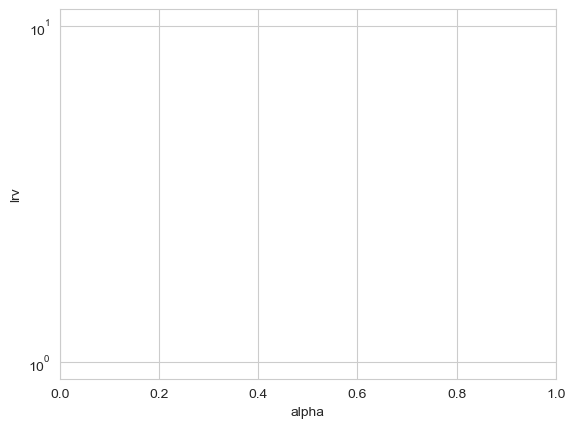

In [12]:
fig, ax = plt.subplots()

# ax.set_xscale('log')
ax.set_yscale("log")

sub_df = df[df["lrv_stat"] == "t_stat_1"]
sub_df = sub_df[sub_df["is_oracle"] == True]
sub_df = sub_df[sub_df["is_complex_gaussian"] == True]

sns.lineplot(
    sub_df[["alpha", "lrv", "is_complex_gaussian", "N"]].abs(),
    x="alpha",
    y="lrv",
    hue="N",
    errorbar=("ci", 95),
    marker="o",
    ax=ax,
)

# save fig
fig.savefig(storage_path / "clt_arma_large_alpha.png")